<a href="https://colab.research.google.com/github/KangTuna/Machine-learning-and-deep-learning-practices/blob/main/PINN_%EC%9E%90%EC%9C%A0%EB%82%99%ED%95%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torch import autograd

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [ ]:
# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/PINN/PINN_ex1.xlsx')

In [ ]:
data

In [ ]:
train_time = 40

In [ ]:
x_train = data.loc[:train_time,'time'].values
y_train = data.loc[:train_time,'Height(m)'].values

In [ ]:
x_test = data.loc[train_time+1:,'time'].values
y_test = data.loc[train_time+1:,'Height(m)'].values

In [ ]:
x_train = torch.Tensor(x_train).reshape(-1,1).to(device)
y_train = torch.Tensor(y_train).reshape(-1,1).to(device)

In [ ]:
x_test = torch.Tensor(x_test).reshape(-1,1).to(device)
y_test = torch.Tensor(y_test).reshape(-1,1).to(device)

In [ ]:
n_input = 1
n_output = 1
n_hidden = 50

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.l1 = nn.Linear(n_input,n_hidden)
    self.l2 = nn.Linear(n_hidden,n_hidden)
    self.l3 = nn.Linear(n_hidden,n_hidden)
    self.l4 = nn.Linear(n_hidden,n_output)

    self.relu = nn.ReLU()

  def forward(self,x):
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    x = self.l3(x)
    x = self.relu(x)
    x = self.l4(x)
    return x

In [ ]:
# 난수 고정
torch.cuda.manual_seed(123)
# 모델 인스턴스 생성
model = Net()
# 모델을 GPU로 전송
model = model.to(device)
# 학습률
lr = 0.001
# 최적화 알고리즘 : 경사 하강법
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
loss_train_record = []
loss_test_record = []
for epoch in range(10000):
  optimizer.zero_grad()

  preds_train = model(x_train)
  preds_test = model(x_test)

  loss_train = nn.MSELoss()(preds_train,y_train)
  loss_test = nn.MSELoss()(preds_test,y_test)

  loss_train.backward()
  optimizer.step()

  loss_train_record.append(loss_train.item())
  loss_test_record.append(loss_test.item())
  if epoch % 1000 == 0:
    print(f'epoch{epoch} loss:{loss_train.item()}, loss_valid:{loss_test.item()}')

In [ ]:
def ODE(t):
  return -9.8*t

In [ ]:
x_H0 = torch.Tensor([0])
y_H0 = torch.Tensor([1000])

In [ ]:
time_start = data.loc[0,'time']
time_end = data.loc[len(data)-1,'time']

In [ ]:
N_colloc = 1000

X_colloc = torch.rand(N_colloc,1)*(time_end - time_start) + time_start

In [ ]:
X_colloc = X_colloc.to(device)
x_H0 = x_H0.to(device)
y_H0 = y_H0.to(device)

In [ ]:
class PINN_test(nn.Module):
  def __init__(self):
    super().__init__()

    self.l1 = nn.Linear(1,50)
    self.l2 = nn.Linear(50,50)
    self.l3 = nn.Linear(50,50)
    self.l4 = nn.Linear(50,1)

    self.tanh = nn.Tanh()

  def forward(self,x):
    x = self.l1(x)
    x = self.tanh(x)
    x = self.l2(x)
    x = self.tanh(x)
    x = self.l3(x)
    x = self.tanh(x)
    x = self.l4(x)
    return x

In [ ]:
torch.cuda.manual_seed(123)
model_P = PINN_test()
model_P = model_P.to(device)
optimizer_P = torch.optim.Adam(model_P.parameters(),lr=lr)

In [ ]:
loss_train_P = []
loss_test_P = []
steps = 50000
for i in range(steps):
  loss_BC = nn.MSELoss()(model_P.forward(x_H0),y_H0)
  X_colloc.requires_grad = True
  f = model_P.forward(X_colloc)
  f_x = autograd.grad(f,X_colloc,torch.ones([X_colloc.shape[0],1]).to(device),
                      retain_graph=True, create_graph = True)[0]
  loss_ODE = nn.MSELoss()(f_x,ODE(X_colloc))
  loss_Data = nn.MSELoss()(model_P.forward(x_train),y_train)
  loss = loss_BC + loss_ODE + loss_Data

  loss_test = nn.MSELoss()(model_P.forward(x_test),y_test)
  optimizer_P.zero_grad()
  loss.backward()
  optimizer_P.step()

  loss_train_P.append(loss.item())
  loss_test_P.append(loss_test.item())
  if i %(steps/10) == 0:
    print(loss)

tensor(1813631.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(990631.1875, device='cuda:0', grad_fn=<AddBackward0>)
tensor(446331.3750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(133948.5156, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11936.7266, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9642, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.3930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2253, device='cuda:0', grad_fn=<AddBackward0>)


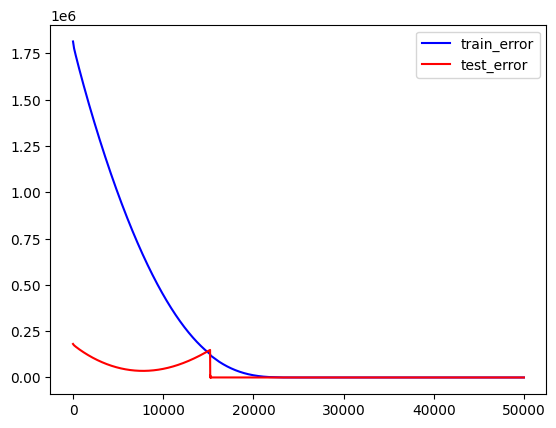

In [ ]:
plt.plot(loss_train_P,'b',label = 'train_error')
plt.plot(loss_test_P,'r',label = 'test_error')
plt.legend()
plt.show()

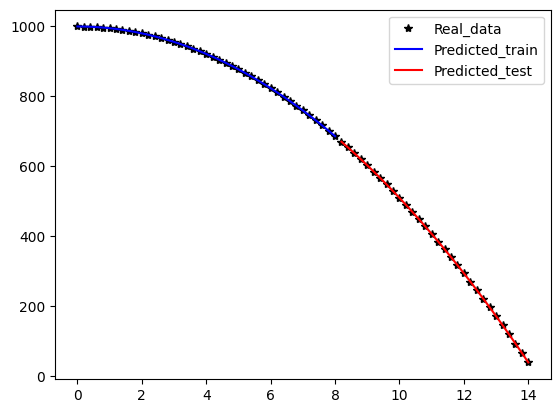

In [ ]:
plt.plot(data['time'],data['Height(m)'],'*',color='black',label='Real_data')
plt.plot(x_train.cpu(),model_P(x_train).detach().cpu(),color = 'blue',label = 'Predicted_train')
plt.plot(x_test.cpu(),model_P(x_test).detach().cpu(),color = 'red',label = 'Predicted_test')
plt.legend(loc = 'upper right')